<h1><b>Tubes B</b></h1>
<h4>Implementasi Backpropagation</h4>

Anggota Kelompok:
- 13520001 - Fayza Nadia
- 13520014 - Muhammad Helmi Hibatullah
- 13520026 - Muhammad Fajar Ramadhan
- 13520029 - Muhammad Garebaldhie Er Rahman

# Models

Model yang dibuat menggunakan format seperti berikut

file `sigmoid.json`
```json
{
  "case": {
    "model": {
      "input_size": 2,
      "layers": [
        {
          "number_of_neurons": 3,
          "activation_function": "sigmoid"
        }
      ]
    },
    "input": [
      [0.0, 0.0],
      [0.0, 0.1]
    ],
    "initial_weights": [
      [
        [0.1, 0.2, 0.3],
        [0.4, 0.5, 0.6],
        [0.9, 0.1, 0.2]
      ]
    ],
    "target": [
      [0.1, 1.0],
      [1.0, 0.0]
    ],
    "learning_parameters": {
      "learning_rate": 0.1,
      "batch_size": 2,
      "max_iteration": 1,
      "error_threshold": 0.1
    }
  },
  "expect": {
    "stopped_by": "max_iteration",
    "final_weights": [
      [
        [0.1, 2.86, 0.17],
        [0.5, -2.46, 0.41],
        [0.9, 0.0, -1.76]
      ]
    ]
  }
}
```

1. `model`: Terdiri dari ukuran input yang diterima dan input layer yang berisi jumlah neuron serta fungsi aktivasi (linear, relu, sigmoid, softmax).

2. `input`: Menyatakan input yang terdiri dari 2 dimensi.
- dimensi 1 merupakan vektor ke-i.
- dimensi 2 merupakan isi suatu vektor.

3. `initial_weights`: Menyatakan inisiasi bobot pada awal.
- dimensi 1 bersesuaian dengan layers
- dimensi 2 berukuran banyak neuron pada layer sebelumnya + 1 dengan layer pertama adalah ukuran input + 1 serta baris pertama merupakan bias.
- dimensi 3 berukuran banyak neuron pada layer yang bersesuaian.

4. `target`: Menyatakan hasil output dari backpropagation.
- dimensi 1 berukuran sama dengan dimensi 1 pada input.
- dimensi 2 berukuran sama dengan banyak neuron pada layer terakhir.

5. `learning_parameters`: Parameter yang terdiri dari learning rate, batch size, max iteration, dan error threshold.

6. `stopped_by`: Berisi 2 nilai valid, yaitu max iteration atau error threshold, sebagai penentu terminasi.

7. `final_weights`: Bobot akhir yang digunakan untuk pengecekan setelah seluruh iterasi dijalankan.

#### Installing Dependencies 

In [21]:
%pip install numpy pandas graphviz scikit-learn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\mfaja\appdata\roaming\python\python311\site-packages (1.23.5)




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<h3><b>Class & Function</b></h3>

<b>Import</b>

In [22]:
import math
import numpy as np
import json
import os
from graphviz import Digraph
from typing import List, Dict

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier

<b>Activation</b>

Class Activation adalah kelas yang berisi fungsi-fungsi aktivasi yang digunakan pada neural network. Fungsi-fungsi tersebut adalah linear, relu, sigmoid, dan softmax.

In [23]:
class Activation:
    LINEAR = "linear"
    RELU = "relu"
    SIGMOID = "sigmoid"
    SOFTMAX = "softmax"

    def __init__(self, mode) -> None:
        self.mode = mode

    def __linear_calculate(self, res):
        return res

    def __linear_derivative(self, res):
        return np.ones(np.shape(res))

    def __sigmoid_calculate(self, res):
        res = np.array([(1 / (1 + pow(math.e, -x))) for x in res])
        return res

    def __sigmoid_derivative(self, res):
        return res * (1 - res)

    def __relu_calculate(self, res):
        res[res < 0] = 0
        return res

    def __relu_derivative(self, res):
        res_copy = res.copy()
        res_copy[res_copy <= 0] = 0
        res_copy[res_copy > 0] = 1
        return res_copy

    def __softmax_calculate(self, res):
        numerator = np.array([pow(math.e, x) for x in res])
        denominator = np.array([np.sum(pow(math.e, x)) for x in res])
        result = np.empty(numerator.shape)

        for index, ele in enumerate(numerator):
            result[index] = ele / denominator[index]

        return result

    def __softmax_derivative(self, res, target=[]):
        """ 
        if t == 1 then -(1-o) -> o - 1
        """
        subtract = np.subtract(res, target)
        return np.array(subtract)

        return res

    def calculate(self, x, w, b):
        res = np.matmul(x, w)
        res = np.add(res, b)
        if self.mode == Activation.LINEAR:
            return self.__linear_calculate(res)
        elif self.mode == Activation.RELU:
            return self.__relu_calculate(res)
        elif self.mode == Activation.SIGMOID:
            return self.__sigmoid_calculate(res)
        elif self.mode == Activation.SOFTMAX:
            return self.__softmax_calculate(res)
        else:
            raise Exception(
                "Mode is not implemented, please select correct mode")

    def derivative(self, res, target=[]):
        if self.mode == Activation.LINEAR:
            return self.__linear_derivative(res)
        elif self.mode == Activation.RELU:
            return self.__relu_derivative(res)
        elif self.mode == Activation.SIGMOID:
            return self.__sigmoid_derivative(res)
        elif self.mode == Activation.SOFTMAX:
            return self.__softmax_derivative(res, target)
        else:
            raise Exception(
                "Mode is not implemented, please select correct mode")

    def predict(self, res):
        if self.mode == Activation.LINEAR:
            return res
        elif self.mode == Activation.RELU:
            return res
        elif self.mode == Activation.SIGMOID:
            return res
        elif self.mode == Activation.SOFTMAX:
            return res
        else:
            raise Exception(
                "Mode is not implemented, please select correct mode")



<b>Reader</b>

Class Reader adalah kelas yang berfungsi untuk membaca berkas json yang berisi model FFNN.

In [24]:
ACTIVATION_LIST = [Activation.LINEAR, Activation.RELU,
                   Activation.SIGMOID, Activation.SOFTMAX]

MAX_SSE = 1e-8
BASE_FFNN_PATH = "test/test_case_ffnn/"
BASE_BACKPROP_PATH = "test/test_case_backprop/"


class Reader:
    def __init__(self) -> None:
        pass

    @staticmethod
    def read_ffnn(filename: str) -> Dict:
        """ 
        Read ffnn models from json
        """
        try:
            with open(BASE_FFNN_PATH + filename, "rb") as f:
                json_file = json.load(f)
                # Return models
                if validate_data(json_file):
                    return json_file
                return None
        except OSError as e:
            print("File not found")
            os._exit(-1)

    @staticmethod
    def read_backprop(filename: str) -> Dict:
        """ 
        Read json file for backprogation test case
        """
        try:
            with open(BASE_BACKPROP_PATH + filename, "rb") as f:
                json_file = json.load(f)
                raw_model = json_file["case"]
                transformed_model = transform_to_ffnn_model(raw_model)
                expected = json_file["expect"]

                return raw_model, transformed_model, expected

        except OSError as e:
            print("File not found")
            os._exit(-1)


def transform_to_ffnn_model(input_model: dict):
    """ 
    Needed to trasnsform to the current FFNN model
    """
    model = {}
    model["layers"] = len(input_model["model"]["layers"]) + 1
    model["activation_functions"] = [x["activation_function"]
                                     for x in input_model["model"]["layers"]]
    model["neurons"] = [input_model["model"]["input_size"]] + [x["number_of_neurons"]
                                                               for x in input_model["model"]["layers"]]
    model["weights"] = [np.transpose(x)
                        for x in input_model["initial_weights"]]
    model["rows"] = len(input_model["input"])
    model["data"] = input_model["input"]
    model["target"] = input_model["target"]
    model["max_sse"] = MAX_SSE

    return model


def validate_data(json_data) -> bool:
    """ 
    Validate input data .json
    """

    # Validate layers
    layers = json_data['layers']
    activation_functions = np.array(
        json_data['activation_functions'], dtype=np.string_)

    # Neurons are input hidden output
    neurons = np.array(json_data['neurons'], dtype=np.int32)
    weights = json_data['weights']
    rows = json_data['rows']
    data = np.array(json_data['data'], dtype=np.float64)
    data_names = np.array(json_data['data_names'], dtype=np.string_)
    target_names = np.array(json_data['target_names'], dtype=np.string_)
    target = np.array(json_data['target'], dtype=np.int32)
    max_sse = json_data['max_sse']

    if not isinstance(layers, int):
        raise Exception("Layers is not integer")

    # Validate activation function per layers
    if activation_functions.shape[0] != layers - 1:
        raise Exception("Length of activation functions is not the same")

    for function in activation_functions:
        if function.decode() not in ACTIVATION_LIST:
            raise Exception("Invalid activation functions")

    # # Validate neurons
    if neurons.shape[0] != layers:
        raise Exception("Neurons number don't match with layers")

    assert neurons.dtype == np.int32

    # Validate weights, weights must be layers - 1
    if len(weights) != layers - 1:
        raise Exception("Please input correct weights")

    for index, weight_per_neuron in enumerate(weights):
        for weight_neuron in weight_per_neuron:
            if len(weight_neuron) != neurons[index] + 1:
                raise Exception(
                    f"Invalid number of weights parameter in weight {index}")
            np.array(weight_neuron, dtype=np.float64)

    # Validate rows
    if not isinstance(rows, int):
        raise Exception("Rows is not integer")

    # data_names
    len_data_features = data_names.shape[0]
    assert np.issubdtype(data_names.dtype, np.string_) == True

    # data attr
    if data.shape[0] != rows:
        raise Exception("Number of data doesn't match with rows")

    if data.shape[1] != len_data_features:
        raise Exception("Number of data columns doesnt match")

    assert np.issubdtype(target_names.dtype, np.string_) == True
    assert target.shape[0] == rows

    if not isinstance(max_sse, float):
        raise Exception("Please input correct sse")

    return True

<b>FFNN Algorithm</b>

Class FFNN adalah kelas yang berfungsi untuk mengimplementasikan algoritma forward propagation pada FFNN.

In [25]:
class FFNN:
    def __init__(self, model) -> None:
        self.layers = model['layers']
        self.activation_functions = np.array(model['activation_functions'])
        self.neurons = np.array(model['neurons'])
        self.weights = model['weights']
        self.data = np.array(model['data'])
        self.target = np.array(model['target'])
        self.output = None
        self.ouput_per_layer = []
        self.max_sse = model["max_sse"]
        pass

    def __str__(self) -> str:
        return f"\
  Layers: {self.layers}\n\
  Activations: {self.activation_functions}\n\
  Neurons: {self.neurons}\n\
  Weights: {self.weights}\n\
  Data: {self.data}\n\
  target: {self.target}\n\
  max_sse: {self.max_sse}\n"

    # Will return output functions
    def compute(self):
        res = self.data
        for i in range(self.layers - 1):
            activation_function = Activation(
                self.activation_functions[i])
            transposed_weights = np.transpose(np.array(self.weights[i]))
            weights, bias = self.separate_bias(transposed_weights)
            res = activation_function.calculate(res, weights, bias)
            self.ouput_per_layer.append(res)
        self.output = res
        return res

    def get_all_output_layer(self):
        return self.ouput_per_layer

    def separate_bias(self, data):
        bias = data[0, :]
        weight = data[1:, :]
        return weight, bias

    def predict(self):
        A = Activation(self.activation_functions[-1])
        res = A.predict(self.output)
        sse = self._calculate_sse()
        print(f"\
  Data: {self.data}\n\
  Target: {self.target}\n\
  Predictions: {res}\n\
  SSE: {sse}\n\
  isValid: {[s < self.max_sse for s in sse]} ( < {self.max_sse})\n")

    def _calculate_sse(self):
        sse = 0
        for i in range(len(self.output)):
            sse += pow(self.output[i] - self.target[i], 2)
        sse = sse / 2
        return sse

<b>Graph</b>

Class Graph adalah kelas yang berfungsi untuk menggambar grafik dari hasil forward propagation.

In [26]:
class Graph:
    def __init__(self, ffnn: FFNN, filename: str) -> None:
        self.ffnn = ffnn
        self.filename = filename
        self.f = Digraph(
            'G', filename=f'./res/{self.filename}_graph', format='png')

    def draw(self):
        self.f.attr('node', shape='circle')
        self._add_node()
        self._add_edge()
        self.f.view()
        return self.f

    def _add_node(self):
        # Add input nodes
        self.f.node("b1")
        # Pake data aja
        for index, data_name in enumerate(self.ffnn.data[0]):
            self.f.node(f"x{index}")

        # Add nodes in the next layers
        for layer in range(1, self.ffnn.layers - 1):
            self.f.node(f"b{layer+1}")
            for j in range(self.ffnn.neurons[layer]):
                self.f.node(f"h{layer}{j+1}")

    def _add_edge(self):
        # Add edges between layers
        layers = self.ffnn.layers

        for layer in range(layers - 1):
            transposed_weights = np.transpose(
                np.array(self.ffnn.weights[layer]))
            weights, bias = self.ffnn.separate_bias(transposed_weights)

            # Add edges between bias and hidden layer or output
            for i in range(len(bias)):
                if layers == 2:
                    bias_name = f"b{layer+1}"
                    end = f"y{i+1}"
                else:
                    bias_name = f"b{layer+1}"
                    end = f"h{layer+1}{i+1}"
                    if layer == self.ffnn.layers - 2:
                        end = f"y{i+1}"

                self.f.edge(bias_name, end, label=f"{bias[i]}")

            # Add edges between input and hidden layer or output
            for i in range(self.ffnn.neurons[layer]):
                for j in range(len(weights[i])):
                    if layers == 2:
                        start = str(f"x{i}")
                        end = f"y{j+1}"
                    elif layer == 0:
                        start = str(f"x{i}")
                        end = f"h{layer+1}{j+1}"
                    elif layer == self.ffnn.layers - 2:
                        start = f"h{layer}{i+1}"
                        end = f"y{j+1}"
                    else:
                        start = f"h{layer}{i+1}"
                        end = f"h{layer+1}{j+1}"
                    self.f.edge(start, end, label=f"{weights[i][j]}")

## Backprop
Backpropgation implementation

In [27]:
MAX_SSE = 1e-8


class Backpropagation:
    def __init__(self, model, expected, ffnn_model) -> None:
        self.input_size = model["model"]["input_size"]
        self.layers = model["model"]["layers"]
        self.input = np.array(model["input"])
        self.weights = np.array(model["initial_weights"])
        self.target = np.array(model["target"])
        self.learning_rate = model["learning_parameters"]["learning_rate"]
        self.batch_size = model["learning_parameters"]["batch_size"]
        self.max_iteration = model["learning_parameters"]["max_iteration"]
        self.error_threshold = model["learning_parameters"]["error_threshold"]
        self.expected = expected
        self.ffnn_model = ffnn_model
        self.single_output = None
        self.output = None

    def forward_propagation(self):
        """ 
        Propagate Forward using FFNN
        """
        ffnn = FFNN(self.ffnn_model)
        res = ffnn.compute()
        self.single_output = res
        self.output = np.array(ffnn.get_all_output_layer())

    def back_propagate(self):
        """ 
        epoch: banyaknya iterasi pada setiap 

        batch_size paramater ukuran minibatch utk Stochastic gradient descent

        step: pemrosesan satu minibatch

        """
        total_batch = self.split_input_targets_to_batch(
            self.input, self.target, self.batch_size)

        epoch = 0
        self.forward_propagation()
        current_epoch_error = self.__loss(
            self.target, self.single_output, self.layers[-1]["activation_function"])

        print("="*6 + " Backpropagation start " + "="*6)

        # Selama belum gg, backpropagate , update bobot trs feed lagi kedepan
        while (epoch == 0) or (epoch < self.max_iteration and current_epoch_error >= self.error_threshold):
            total_layer = len(self.layers)
            prev_error = None

            print("=" * 8 + f" EPOCH {epoch + 1} " + "=" * 8)
            print(f"ERROR: {current_epoch_error}")

            delta_weights_total = []
            list_delta_error_total_layer = []

            for index_batch, batch_instance in enumerate(total_batch):
                inputs = np.array(batch_instance["inputs"])
                targets = np.array(batch_instance["targets"])

                # For each batch, backpropagate
                for index_layer in range(total_layer - 1, -1, -1):
                    gradient = None

                    current_activation = self.layers[index_layer]["activation_function"]
                    output_layer = self.output[index_layer]
                    a = Activation(current_activation)
                    
                    delta_weights = np.zeros(self.weights[index_layer].shape)
                    delta_error_current_layer = []

                    for instance_index, instance in enumerate(inputs):

                        # Kalau dia punya output (layer paling ujung)
                        if index_layer == total_layer - 1:
                          
                            # Calculate dho error / dho weight
                            # First part: -(t - o) -> (o - t)
                            first_part = np.subtract(
                                output_layer[instance_index], targets[instance_index])

                            # Second part: derivative
                            second_part = a.derivative(
                                output_layer[instance_index], targets[instance_index])

                            # Third part: input di layer sebelumnya
                            third_part = None

                            # Kalau cuma 1 layer, pake input layer
                            # add bias
                            if len(self.output) == 1:
                                third_part = np.ones(
                                    instance.shape[0] + 1)
                                third_part[1:] = instance
                            else:
                                shape = self.output[index_layer -
                                                    1][instance_index].shape
                                third_part = np.ones(shape[0] + 1)
                                third_part[1:] = self.output[index_layer -
                                                             1][instance_index]

                            # Third part must same as len each inital weights transposed
                            cur_weights = np.transpose(
                                self.weights[index_layer])
                            third_parts = np.zeros(cur_weights.shape)

                            for i in range(len(cur_weights)):
                                third_parts[i] = third_part

                            third_parts = np.transpose(third_parts)

                            if current_activation == Activation.SOFTMAX:
                                prev_error = second_part
                            else:
                                prev_error = np.multiply(
                                    first_part, second_part)

                            gradient = np.multiply(prev_error, third_parts)

                        # Kalau hidden layer
                        else:
                            # Calculate dho error / dho weight
                            # First part: dho error / dho net

                            # dho Ed / dho net_o; prev error
                            # print(prev_error)
                            # dho net_o / dho h
                            # remove bias
                            # print(next_layer_cur_weights)
                            next_layer_cur_weights = self.weights[index_layer + 1][1:]
                            print(list_delta_error_total_layer[-1])
                            prev_error = list_delta_error_total_layer[-1][instance_index]

                            # dho Ed / dho h
                            temp = np.dot(next_layer_cur_weights, prev_error)

                            # calculate sum of the error outputs layer
                            # output_layer_sum_error = np.array(
                            #     [np.sum(x) for x in temp])
                            derivative = a.derivative(
                                output_layer[instance_index], targets[instance_index])

                            derivative = np.array(derivative)

                            # calculate prev error
                            prev_error = np.multiply(
                                temp, derivative)

                            # Second part: dho net / dho weight
                            second_part = None

                            # Kalau udah paling ujung
                            if index_layer == 0:
                                second_part = np.ones(instance.shape[0] + 1)
                                second_part[1:] = instance
                            else:
                                shape = self.output[index_layer][instance_index].shape
                                second_part = np.ones(shape[0] + 1)
                                second_part[1:] = self.output[index_layer][instance_index]

                            cur_weights = np.transpose(self.weights[i])
                            second_parts = np.zeros(cur_weights.shape)
                            for i in range(len(cur_weights)):
                                second_parts[i] = second_part

                            second_parts = np.transpose(second_parts)
                            gradient = np.multiply(prev_error, second_parts)
                            # print(gradient)

                        # Update delta weights
                        delta_weights = delta_weights - \
                            np.dot(self.learning_rate, gradient)

                        delta_error_current_layer.append(prev_error)

                    list_delta_error_total_layer.append(
                        delta_error_current_layer)

                    delta_weights_total.append(delta_weights)

                # Update weight
                delta_weights_total.reverse()
                self.weights = self.weights + np.array(delta_weights_total)

                print(
                    f"Batch {index_batch + 1} completed")

                new_weights = [np.transpose(x) for x in self.weights]
                self.ffnn_model["weights"] = new_weights
                self.forward_propagation()
                current_epoch_error = self.__loss(
                    self.target,  self.single_output, self.layers[-1]["activation_function"])

            epoch += 1

        print("Backpropagation complete")
        if current_epoch_error < self.error_threshold:
            print(
                f"Reason: error ({current_epoch_error}) < threshold ({self.error_threshold})")
        else:
            print("Reason: Max iteration reached")

        print("Final output")
        print(self.single_output)
        print("Final weights")
        print(self.weights)
        print("Excpected")
        try:
            print(np.array(self.expected["final_weights"]))
        except:
            print("No expected final weights in the test case")

    def split_input_targets_to_batch(self, inputs: List, targets: List, batch_size: int) -> List[List]:
        """ 
        Split input and targets into batch
        """

        total_batch = []
        ctr = 0
        cur_input = []
        cur_target = []

        length = len(inputs)
        for i in range(length):
            cur_target.append(targets[i])
            cur_input.append(inputs[i])

            ctr += 1

            if ctr == batch_size:
                total_batch.append({
                    "inputs": cur_input,
                    "targets": cur_target
                })

                ctr = 0
                cur_target = []
                cur_input = []

        return total_batch

    def __loss(self, target, pred, activation):
        """ 
        For linear, sigmoid, relu use SSE.

        Softmax use cross entropy 
        """
        if activation == Activation.SOFTMAX:
            return self.__cross_entropy(target, pred)
        else:
            return self.__sse(target, pred)

    def __sse(self, target, pred):
        """ 
        Calculate errors using sse

        sum squared of (target - pred )/ 2
        """
        total = 0
        length = len(pred)
        for i in range(length):
            total += pow(target[i] - pred[i], 2)
        return np.sum(total) / 2

    def __cross_entropy(self, target, pred):
        """ 
        Calculate cross entropy

        If target == 1 then -np log pj

        """
        res = 0
        for index, val in enumerate(target):
            for j, t in enumerate(val):
                if t == 1:
                    res += np.sum(-np.log(pred[index][j]))

        return res




<h3><b>Main Program</b></h3>

                Backpropagation              
====== Backpropagation start ======
======== EPOCH 1 ========
ERROR: 0.6649999999999999
Batch 1 completed
Backpropagation complete
Reason: Max iteration reached
Final output
[[ 2.42  0.56 -2.19]
 [ 1.42 -0.74 -0.04]]
Final weights
[[[ 0.22  0.36  0.11]
  [ 0.64  0.3  -0.89]
  [ 0.28 -0.7   0.37]]]
Excpected
[[[ 0.22  0.36  0.11]
  [ 0.64  0.3  -0.89]
  [ 0.28 -0.7   0.37]]]
Graph is saved in folder res with name: linear_graph.png


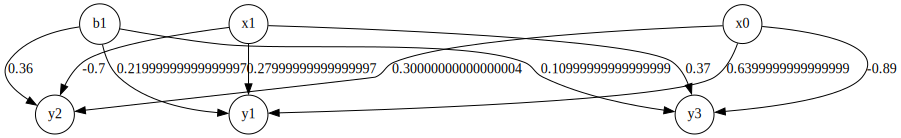

In [28]:
print("=============================================")
print("                Backpropagation              ")
print("=============================================")
filename = input("Input filename inside test folder: ")

# transformed_model = Reader.read_ffnn("softmax.json")
raw_model, ffnn_model, expected = Reader.read_backprop(filename)

b = Backpropagation(raw_model, expected, ffnn_model)
b.back_propagate()

ffnn = FFNN(model=ffnn_model)
filename = filename.split(".")[0]
graph = Graph(ffnn, filename)

print("=============================================")
print("Graph is saved in folder res with name: " +
        filename + "_graph.png")
print("=============================================")
graph.draw()

# Perbandingan model dengan Sklearn

## Sklearn-MLP

In [29]:
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

import numpy as np

def sse(target, res):
    return np.sum(np.sum(np.square(target - res))/2)

def predict_mlp():
    """
    Sklearn multilayer perceptron
    https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 
    When testing:
    1. Change activation
    2. Change batch_size
    """

    iris = load_iris()
    x, y = iris.data, iris.target

    # Encode dataset
    # encoder = OneHotEncoder(sparse_output=False)
    # y_reshaped = y.reshape(len(y), 1)
    # y = encoder.fit_transform(y_reshaped)

    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=100)

    # print("=" * 8 + " Dataset information " + "="*8)
    # print("X Train: ", x_train)
    # print("Y Train: ", y_train)
    # print("X Test: ", x_test)
    # print("Y Test: ", y_test)

    mlp = MLPClassifier(
        # hidden_layer_sizes=(3, 3),
        activation="logistic",
        solver="sgd",
        batch_size=150,
        learning_rate_init=0.0001,
        max_iter=10000,
        verbose=True,
    )

    mlp.fit(x_train, y_train)

    print("=" * 8 + " Result fit " + "="*8)
    # for key in dir(mlp):
    #     print("Key: ", key, "\nValue: ", mlp.__getattribute__(key))

    res = mlp.predict(x_test)
    # print(classification_report(y_test, res))
    # print(confusion_matrix(y_test, res))
    # print(res)
    print("SSE:", sse(y_test, res))

predict_mlp()

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:603: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Iteration 1, loss = 1.12166372
Iteration 2, loss = 1.12156926
Iteration 3, loss = 1.12143489
Iteration 4, loss = 1.12126500
Iteration 5, loss = 1.12106359
Iteration 6, loss = 1.12083432
Iteration 7, loss = 1.12058052
Iteration 8, loss = 1.12030524
Iteration 9, loss = 1.12001123
Iteration 10, loss = 1.11970100
Iteration 11, loss = 1.11937681
Iteration 12, loss = 1.11904072
Iteration 13, loss = 1.11869456
Iteration 14, loss = 1.11834000
Iteration 15, loss = 1.11797854
Iteration 16, loss = 1.11761152
Iteration 17, loss = 1.11724014
Iteration 18, loss = 1.11686549
Iteration 19, loss = 1.11648853
Iteration 20, loss = 1.11611012
Iteration 21, loss = 1.11573102
Iteration 22, loss = 1.11535192
Iteration 23, loss = 1.11497342
Iteration 24, loss = 1.11459605
Iteration 25, loss = 1.11422028
Iteration 26, loss = 1.11384653
Iteration 27, loss = 1.11347517
Iteration 28, loss = 1.11310650
Iteration 29, loss = 1.11274080
Iteration 30, loss = 1.11237832
Iteration 31, loss = 1.11201925
Iteration 32, los

## Current Model

In [30]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

from src.activation import Activation
from src.backprop import Backpropagation
from src.ffnn import FFNN
from src.graph import Graph
from src.reader import Reader

def transform_to_ffnn_model(input_model: dict):
    """ 
    Needed to trasnsform to the current FFNN model
    """
    model = {}
    model["layers"] = len(input_model["model"]["layers"]) + 1
    model["activation_functions"] = [x["activation_function"]
                                     for x in input_model["model"]["layers"]]
    model["neurons"] = [input_model["model"]["input_size"]] + [x["number_of_neurons"]
                                                               for x in input_model["model"]["layers"]]
    model["weights"] = [np.transpose(x)
                        for x in input_model["initial_weights"]]
    model["rows"] = len(input_model["input"])
    model["data"] = input_model["input"]
    model["target"] = input_model["target"]
    model["max_sse"] = 1e-8

    return model

def current_model_predict():

    iris = load_iris()
    x, y = iris.data, iris.target

    encoder = OneHotEncoder(sparse_output=False)
    y_reshaped = y.reshape(len(y), 1)
    y = encoder.fit_transform(y_reshaped)    
    y = np.array(y) 

    input_size = x.shape[1]
    neuron = 3

    initial_weights = [[0.5 for _ in range(neuron)] for _ in range(input_size + 1)]

    model = {
        "case":{
           "model": {
                "input_size": input_size,
                "layers": [
                    {
                        "number_of_neurons": neuron,
                        "activation_function": "sigmoid",
                    },
                ]
           },
           "input": x,
           "initial_weights": [initial_weights],
           "target": y,
           "learning_parameters": {
                "learning_rate": 0.0001,
                "batch_size": 150,
                "max_iteration": 20000,
                "error_threshold": 0.0
            }
        },
        "expect":{
            "stopped_by": "max_iteration",
        }
    }

    raw_model = model["case"]
    ffnn_model = transform_to_ffnn_model(raw_model)
    expected = model["expect"]

    b = Backpropagation(raw_model, expected, ffnn_model)
    b.back_propagate()

current_model_predict()



====== Backpropagation start ======
======== EPOCH 1 ========
ERROR: 149.51888649183266
Batch 1 completed
======== EPOCH 2 ========
ERROR: 149.51849691769561
Batch 1 completed
======== EPOCH 3 ========
ERROR: 149.51810668030018
Batch 1 completed
======== EPOCH 4 ========
ERROR: 149.5177157779267
Batch 1 completed
======== EPOCH 5 ========
ERROR: 149.51732420884937
Batch 1 completed
======== EPOCH 6 ========
ERROR: 149.51693197133653
Batch 1 completed
======== EPOCH 7 ========
ERROR: 149.51653906365055
Batch 1 completed
======== EPOCH 8 ========
ERROR: 149.5161454840475
Batch 1 completed
======== EPOCH 9 ========
ERROR: 149.51575123077754
Batch 1 completed
======== EPOCH 10 ========
ERROR: 149.51535630208468
Batch 1 completed
======== EPOCH 11 ========
ERROR: 149.51496069620683
Batch 1 completed
======== EPOCH 12 ========
ERROR: 149.5145644113756
Batch 1 completed
======== EPOCH 13 ========
ERROR: 149.51416744581647
Batch 1 completed
======== EPOCH 14 ========
ERROR: 149.5137697977488
B